In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = os.path.join("..","datasets","raw","Telco-Customer-Churn.csv")

# Load data
telco = pd.read_csv(DATA_PATH)
print(len(telco))
telco.head().T

7043


,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Null values
telco.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
telco['TotalCharges'].replace(" ", np.nan, inplace=True)
telco.dropna(subset=['TotalCharges'], inplace=True)

# TotalCharges - convert dtype to numeric
telco.TotalCharges = pd.to_numeric(telco.TotalCharges)

In [6]:
# Normalize column names
telco.columns = telco.columns.str.lower().str.replace(' ','_')
# list of categorical columns
string_columns = list(telco.dtypes[telco.dtypes=='object'].index)
# Normalize categorical values
for col in string_columns:
    telco[col] = telco[col].str.lower().str.replace(' ','_')

telco['churn'] = telco.churn.map({'yes':1, 'no':0})

## Exploratory Data Analysis

In [7]:
# dataset lenght
len(telco)

7032

In [8]:
telco.describe().T

,count,mean,std,min,25%,50%,75%,max
seniorcitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthlycharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
totalcharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
churn,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00


In [9]:
# Target variable value count
churn = telco.churn.value_counts()
churn

churn
0    5163
1    1869
Name: count, dtype: int64

Out of a total of 7,043 customers in the telecommunications company's database, 1,869 have churned, representing customers who have discontinued their services. the remaining 5,174 customers have stayed with the company, continuing to use its services.

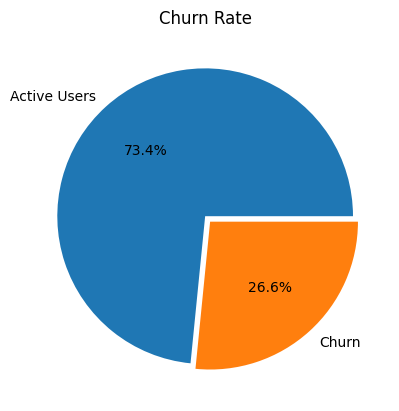

In [10]:
plt.pie(churn, explode=(0,0.05), labels=['Active Users', 'Churn'], autopct='%1.1f%%')
plt.title("Churn Rate")
plt.savefig(os.path.join("..","img","churn_pie_chart.png"))
plt.show()

In percentage terms, represents 26.7% for churned customers and 73.5 for retained customers.

In [11]:
global_mean = telco.churn.mean()
print("Global Mean: {}".format(round(global_mean,3)))

Global Mean: 0.266


In [12]:
numerical_features = ["tenure", "monthlycharges", "totalcharges"]
categorical_features = ["gender", "partner", "seniorcitizen","dependents", "phoneservice", "multiplelines", "internetservice",
"onlinesecurity", "onlinebackup", "deviceprotection", "techsupport", "streamingtv", "streamingmovies", "contract",
"paperlessbilling", "paymentmethod"]

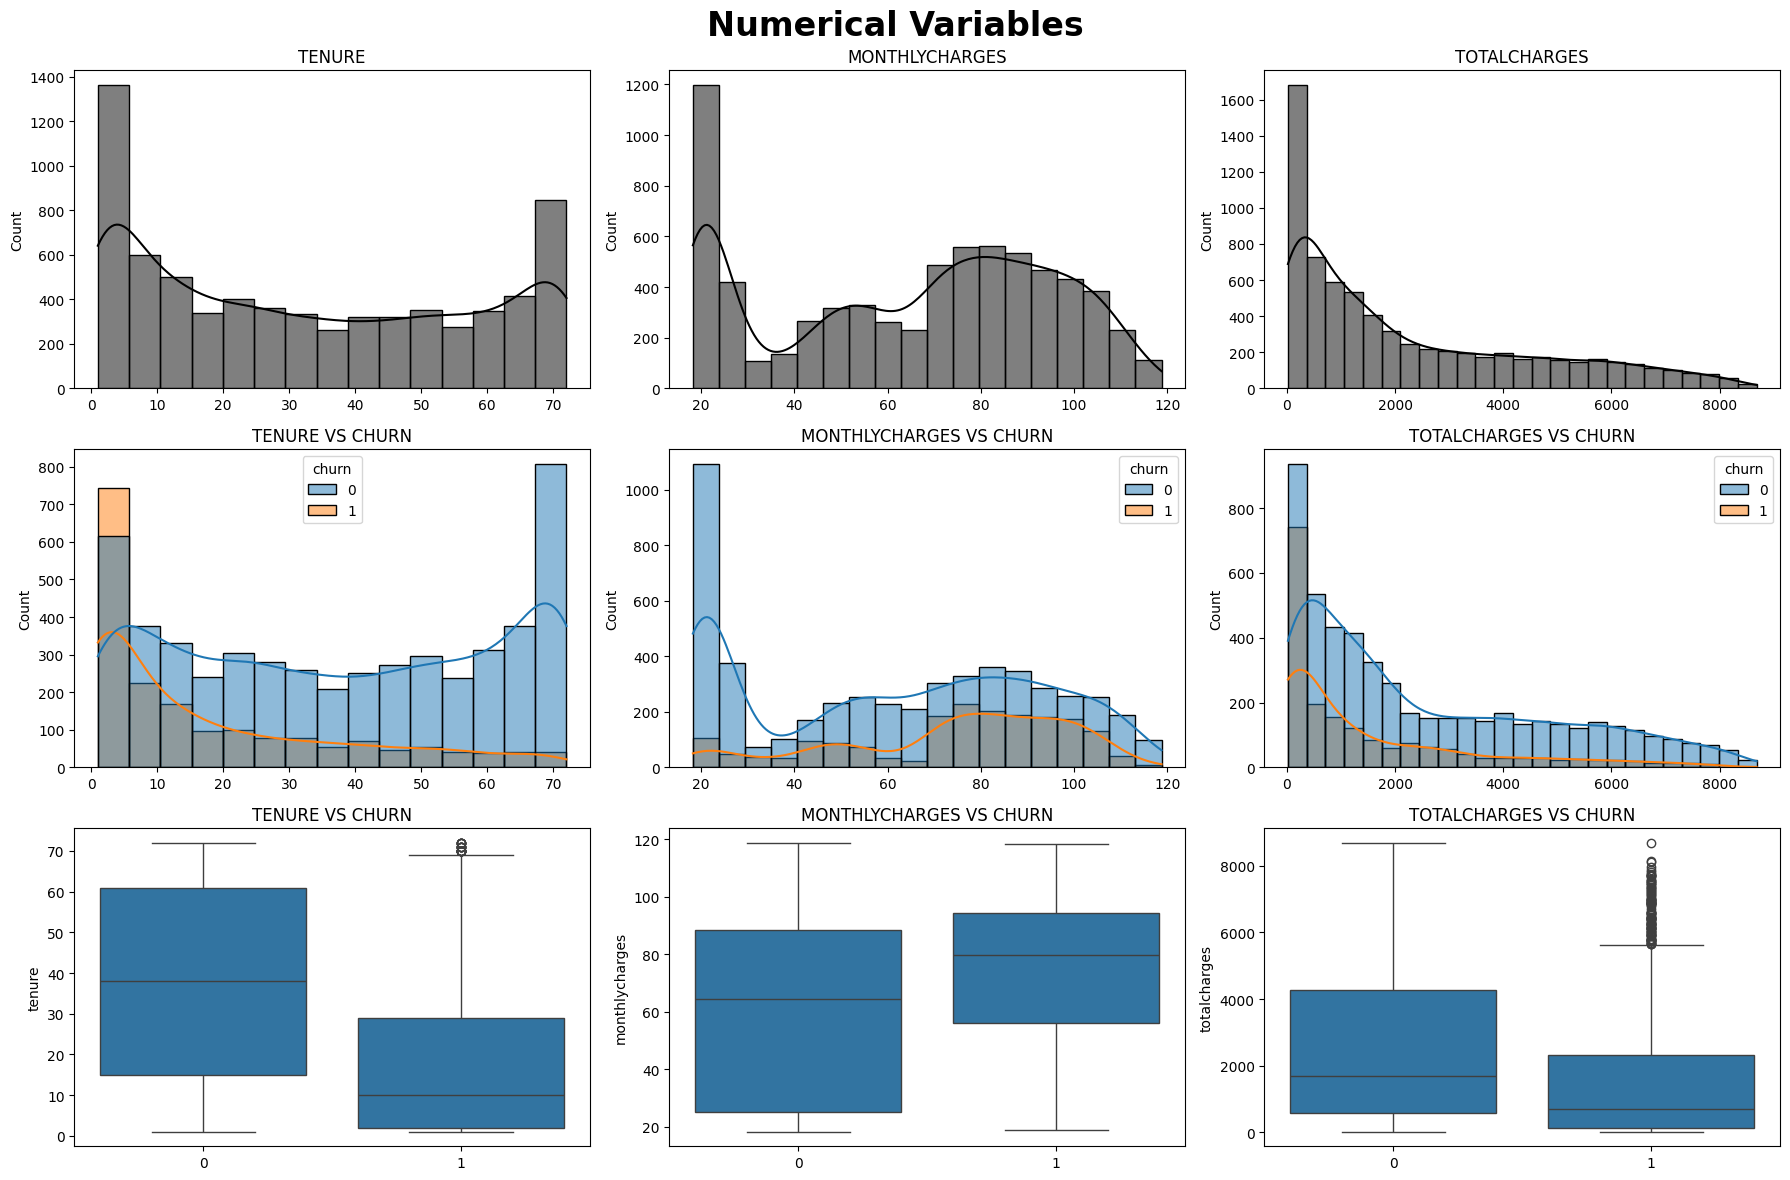

In [13]:
def plot_numericals(df, numerical):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
    ax = ax.flatten()
    plt.suptitle('Numerical Variables', fontweight='bold', fontsize=24)

    for idx, var in enumerate(numerical):
        # Distribution Plots
        sns.histplot(x=var,data=df, kde=True, color="k", ax=ax[idx])
        ax[idx].set_title(var.upper())
        ax[idx].set_xlabel(None)
    
        # vs Churn --- Histograms
        sns.histplot(x=var,data=df, hue='churn', kde=True, ax=ax[idx+3])
        ax[idx+3].set_title((var + ' vs Churn').upper())
        ax[idx+3].set_xlabel(None)
    
        # vs Churn --- Boxplots
        sns.boxplot(y=var, data=df, x='churn', ax=ax[idx+6])
        ax[idx+6].set_title((var + ' vs Churn').upper())
        ax[idx+6].set_xlabel(None)
        
    fig.tight_layout()
    fig.savefig(os.path.join("..","img","num_distributions.png"))
    plt.show()

plot_numericals(telco, numerical_features)

In [15]:
# Mann-Whitney U Test
for col in numerical_features:
    u_stat, p_val = stats.mannwhitneyu(telco[telco['churn']==0][col], telco[telco['churn']==1][col])
    print(col)
    print(f"U statistic: {u_stat}, p-value: {p_val}")
    if p_val < 0.05:
        print("We reject the null hypothesis. There is a statistically significant difference between the two groups.\n")
    else:
        print("We fail to reject the null hypothesis. There is no statistically significant difference between the two groups.\n")
    

tenure
U statistic: 7154668.0, p-value: 6.043046580882717e-211
We reject the null hypothesis. There is a statistically significant difference between the two groups.

monthlycharges
U statistic: 3663498.5, p-value: 8.467195044548749e-54
We reject the null hypothesis. There is a statistically significant difference between the two groups.

totalcharges
U statistic: 6288982.0, p-value: 1.9959848938845826e-84
We reject the null hypothesis. There is a statistically significant difference between the two groups.



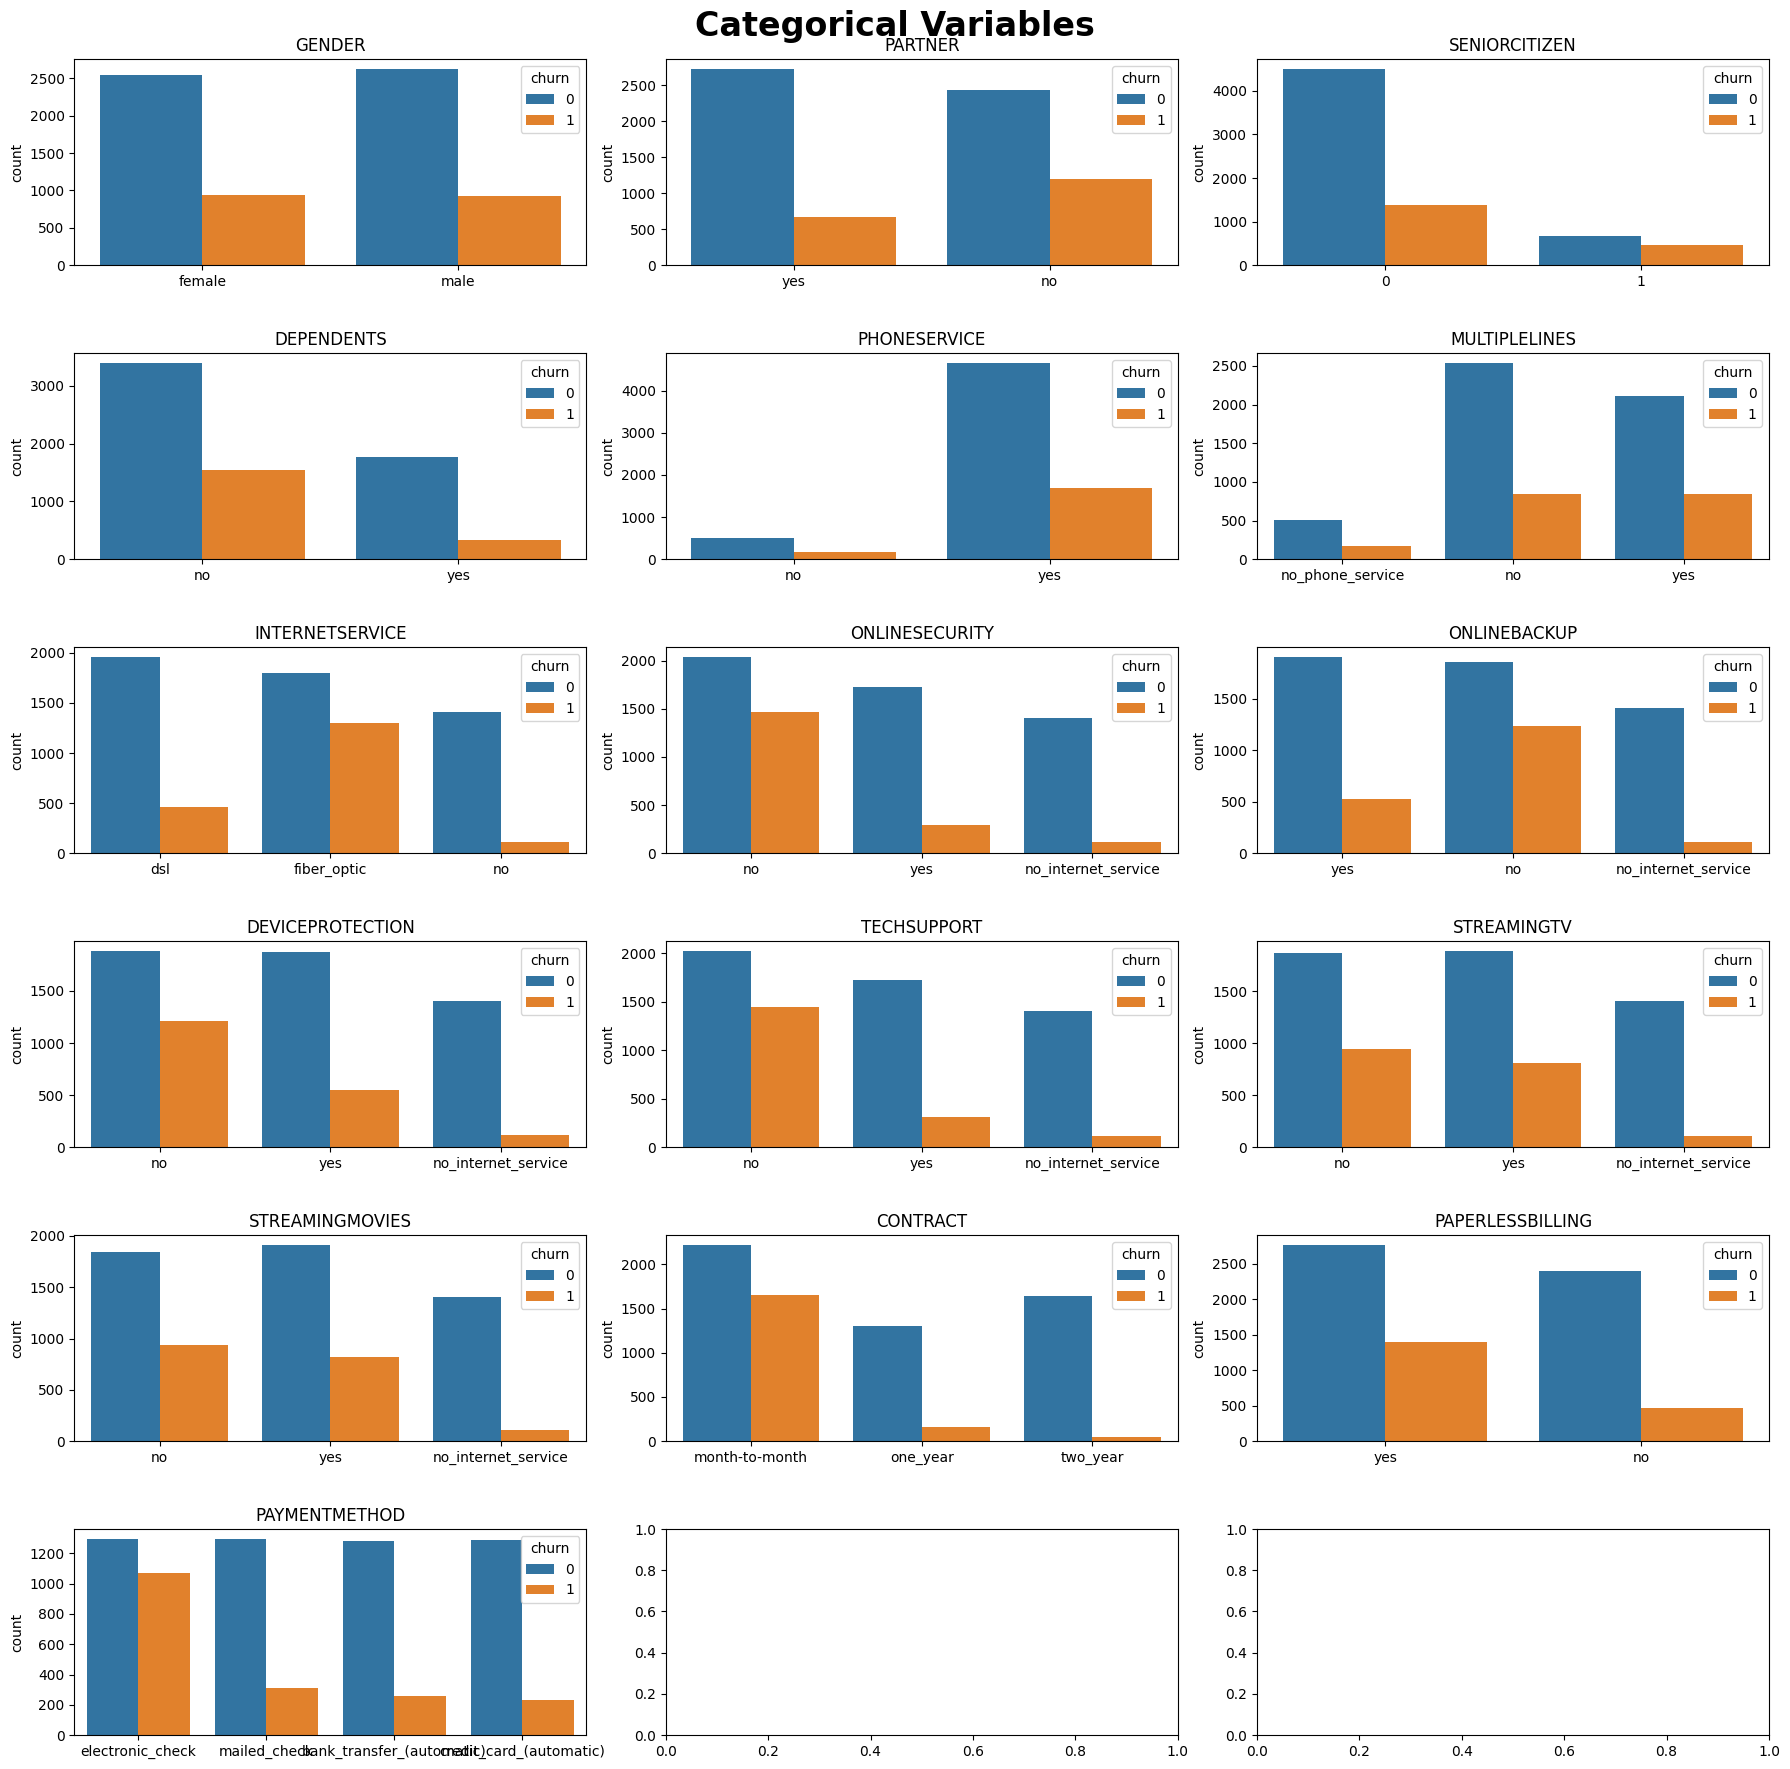

In [14]:
def plot_categorical(df, categorical):
    fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(18,18))
    ax = ax.flatten()
    plt.suptitle('Categorical Variables', fontweight='bold', fontsize=24)

    for idx, var in enumerate(categorical):
        # Distribution Plots
        sns.countplot(x=df[var], hue=df.churn, ax=ax[idx])
        ax[idx].set_title((var).upper())
        ax[idx].set_xlabel(None)
        
    fig.tight_layout(h_pad=3)
    fig.savefig(os.path.join("..","img","cat_distributions.png"))
    plt.show()

plot_categorical(telco, categorical_features)

### Mann-Whitney U Test

### Mutual Information

In [16]:
# Mutual Information
def calculate_mi(series):
    return mutual_info_score(series, telco.churn)

df_mi = telco[categorical_features].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='mi')
df_mi

,mi
contract,0.098182
onlinesecurity,0.064528
techsupport,0.062873
internetservice,0.055394
onlinebackup,0.046659
paymentmethod,0.044423
deviceprotection,0.043784
streamingmovies,0.031918
streamingtv,0.031803
paperlessbilling,0.019119


### Risk ratio

In [17]:
def risk_ratio(df, categorical_features):
    for col in categorical_features:
        global_mean = df.churn.mean()
        df_group =df.groupby(col).churn.agg(['mean'])
        df_group['diff'] = df_group['mean'] - global_mean
        df_group['rate'] = df_group['mean'] / global_mean
        display(df_group)

risk_ratio(telco, categorical_features)

,mean,diff,rate
gender,,,
female,0.269595,0.003810,1.014336
male,0.262046,-0.003739,0.985931


,mean,diff,rate
partner,,,
no,0.329761,0.063976,1.240706
yes,0.197171,-0.068614,0.741843


,mean,diff,rate
seniorcitizen,,,
0,0.236503,-0.029282,0.889827
1,0.416813,0.151028,1.568232


,mean,diff,rate
dependents,,,
no,0.312791,0.047006,1.176859
yes,0.155312,-0.110473,0.584352


,mean,diff,rate
phoneservice,,,
no,0.250000,-0.015785,0.940610
yes,0.267475,0.001690,1.006358


,mean,diff,rate
multiplelines,,,
no,0.250812,-0.014973,0.943667
no_phone_service,0.250000,-0.015785,0.940610
yes,0.286485,0.020700,1.077881


,mean,diff,rate
internetservice,,,
dsl,0.189983,-0.075802,0.714801
fiber_optic,0.418928,0.153143,1.576190
no,0.074342,-0.191443,0.279708


,mean,diff,rate
onlinesecurity,,,
no,0.417787,0.152002,1.571897
no_internet_service,0.074342,-0.191443,0.279708
yes,0.146402,-0.119383,0.550829


,mean,diff,rate
onlinebackup,,,
no,0.399417,0.133632,1.502782
no_internet_service,0.074342,-0.191443,0.279708
yes,0.215670,-0.050115,0.811446


,mean,diff,rate
deviceprotection,,,
no,0.391403,0.125618,1.472629
no_internet_service,0.074342,-0.191443,0.279708
yes,0.225393,-0.040392,0.848027


,mean,diff,rate
techsupport,,,
no,0.416475,0.150690,1.566961
no_internet_service,0.074342,-0.191443,0.279708
yes,0.151961,-0.113824,0.571743


,mean,diff,rate
streamingtv,,,
no,0.335351,0.069566,1.261737
no_internet_service,0.074342,-0.191443,0.279708
yes,0.301147,0.035362,1.133047


,mean,diff,rate
streamingmovies,,,
no,0.337289,0.071504,1.269029
no_internet_service,0.074342,-0.191443,0.279708
yes,0.299524,0.033739,1.126941


,mean,diff,rate
contract,,,
month-to-month,0.427097,0.161312,1.606926
one_year,0.112772,-0.153013,0.424297
two_year,0.028487,-0.237298,0.107179


,mean,diff,rate
paperlessbilling,,,
no,0.163757,-0.102028,0.616126
yes,0.335893,0.070108,1.263775


,mean,diff,rate
paymentmethod,,,
bank_transfer_(automatic),0.167315,-0.098470,0.629513
credit_card_(automatic),0.152531,-0.113254,0.573890
electronic_check,0.452854,0.187069,1.703836
mailed_check,0.192020,-0.073765,0.722464


## Weights - Logistic Regression

In [18]:
telco_dict = telco[categorical_features + numerical_features].to_dict(orient='records')

# DictVectorizer
dv = DictVectorizer(sparse=False)
telco_vec = dv.fit_transform(telco_dict)

# 
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [19]:
# Logistic Regression
model = LogisticRegression(solver='liblinear', random_state=12)
model.fit(telco_vec, telco.churn)

LogisticRegression(random_state=12, solver='liblinear')

In [20]:
# Model Intercept
print("Model Intercept: {}".format(model.intercept_[0]))
# Weights
weights = dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))
weights = pd.Series(weights, index=weights.keys()).sort_values(ascending=False)
weights

Model Intercept: -0.1343449684638785


contract=month-to-month                    0.494
internetservice=fiber_optic                0.326
paymentmethod=electronic_check             0.268
seniorcitizen                              0.245
techsupport=no                             0.227
onlinesecurity=no                          0.224
phoneservice=no                            0.113
multiplelines=no_phone_service             0.113
paperlessbilling=yes                       0.107
onlinebackup=no                            0.086
streamingmovies=yes                        0.077
streamingtv=yes                            0.073
deviceprotection=no                        0.023
dependents=no                              0.018
monthlycharges                             0.002
totalcharges                               0.000
multiplelines=yes                         -0.004
partner=yes                               -0.047
gender=female                             -0.053
deviceprotection=yes                      -0.054
tenure              

## Key Interpretations

### Positive Coefficients (Factors Increasing the Likelihood of Churn):

1. **Contract Type (month-to-month = 0.535):** The most significant factor increasing churn is having a month-to-month contract. This suggests that customers on flexible, short-term contracts are more likely to leave because they are not committed long-term and can switch providers easily.
2. **Internet Service (fiber_optic = 0.323):** The positive coefficient for fiber optic internet indicates that customers with this service are more likely to churn. Despite its high-speed advantage, this could point to several factors:
    - **Higher Expectations:** Customers who opt for fiber optic might have higher expectations for speed and reliability. If these expectations are not met (e.g., due to network issues or service disruptions), their likelihood of dissatisfaction and subsequent churn increases.
    - **Competition and Pricing:** Fiber optic services may come with higher prices or promotional periods that, once expired, lead customers to seek cheaper alternatives.
3. **Payment Method (electronic_check = 0.259):** Customers who pay with electronic checks are more prone to churn. This payment method may be associated with lower customer satisfaction or higher churn risk, potentially due to financial stress or preference for alternative, more convenient options.
4. **Lack of Services (onlinesecurity=no = 0.222, techsupport=no = 0.219):** The absence of online security and tech support correlates with higher churn. This implies that customers who do not have these services may feel less supported or protected, contributing to dissatisfaction and a higher likelihood of leaving.

### Negative Coefficients (factors Reducing the likelihood of Churn)

1. **Contract Type (two-year contract = -0.481):** A two-year contract strongly reduces the likelihood of churn, indicating that customers committed to long-term agreements are less likely to leave. This suggests that stability and commitment are import for customer retention.
2. **Internet Service (dsl = -0.345):** The negative coefficient for DSL suggests that customers using this service are less likely to churn. This could be due to:
    - **Satisfaction with Basic Needs:** DSL, although slower, may meet the needs of users who do not require high- speed connections and value stability over speed.
    - **Wider Coverage:** DSL's broader network coverage may make it the only viable option in some areas, reducing customers' inclination to switch providers.
3. **Phone Service (phoneservice=yes = -0.257):** Having phone service is associated with lower churn, suggesting that bundled services (e.g, internet plus phone) contribute to customer loyalty.
4. **Support Services (onlinesecurity=yes = -0.244, techsupport=yes = -0.241):** Customers with online security and tech support services are less likely to churn, highlighting the importance of value-added  services in maintaining customer satisfaction and retention.
5. **Paperless Billing (no= -0.230):** Customers who do not use paperless billing are les likely to churn. This could be because traditional billing methods correlate with less tech-savvy customers who may be more inclined to stay due to inertia or discomfort with changing to digital systems.

## Summary

Overall, the results indicate that contract flexibility (e.g., month-to-month contracts) and the absence of supportive services (e.g., tech support, online security) are the most influential factors increasing churn. These elements reflect potential dissatisfaction or a lack of commitment, making it easier for customers to switch providers.

On the other hand, long-term contracts, bundled services, and additional support features are significant factors in reducing churn, suggesting that customers who are more invested in their contracts and receive additional services are more satisfied and less likely to leave.